# Blackjack - prediction

In this notebook, we are interested in *learning* the value-function $v_\pi(s)$ and action-value function $q_\pi(s, a)$ for a given policy $\pi$

$$
    S_0, A_0, R_1, S_1, A_1, R_2, \ldots, S_{T-1}, A_{T-1}, R_T
$$

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import blackjack as b21
import matplotlib.pyplot as plt

from numba import njit, prange

In [2]:
%load_ext autoreload
%autoreload 2 

In [3]:
%config InlineBackend.figure_format = "retina"
np.set_printoptions(suppress=True)

* **Stick**: Player stops
* **Hit**: Request an additional card

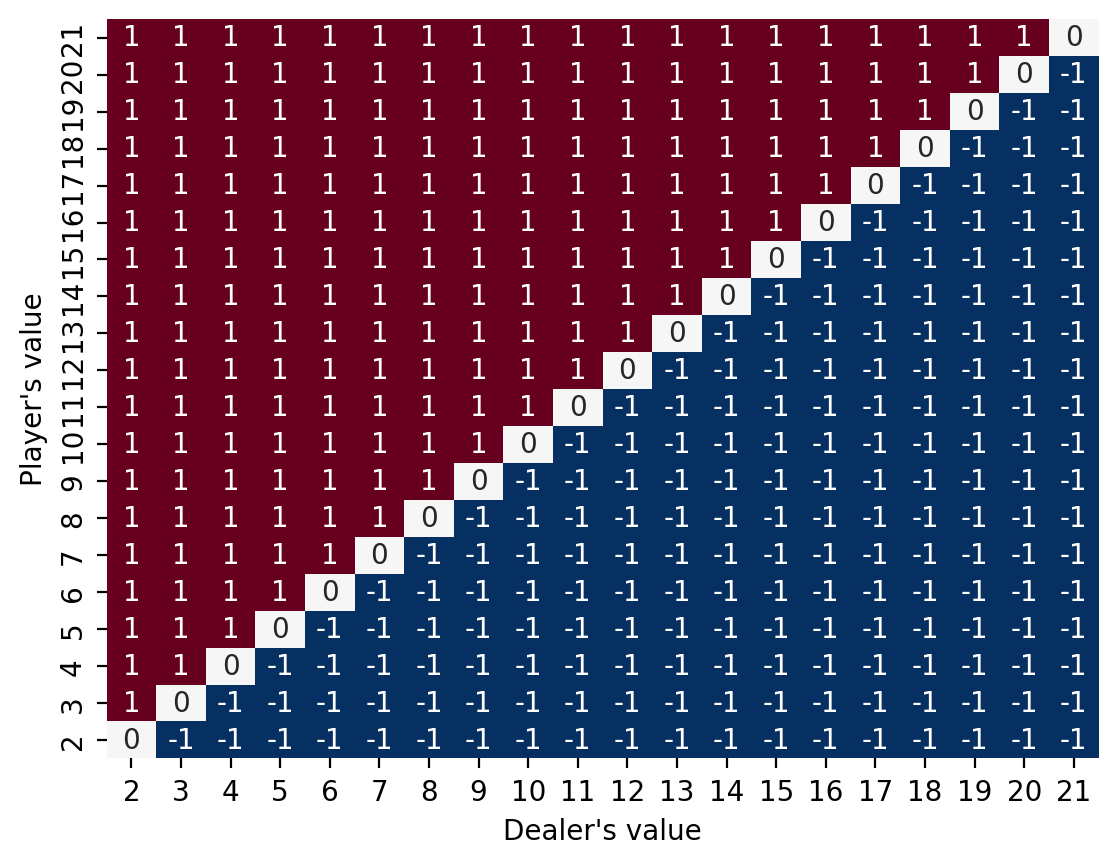

In [4]:
value_cards = np.arange(2, 22)

rewards_grid = np.array([[b21.compute_reward(p, d) for d in value_cards] for p in value_cards])
rewards_grid = pd.DataFrame(rewards_grid, index=value_cards, columns=value_cards)
ax = sns.heatmap(rewards_grid, cmap="RdBu_r", annot=True, cbar=False)
ax.invert_yaxis()
plt.ylabel("Player's value")
plt.xlabel("Dealer's value");

The player makes a decision on the basis of three variables:
1. his current sum (12-21),
2. the dealer's one showing card (ace-10), and
3. whether or not he holds a usable ace

In [5]:
# Number of states
(21 - 12 + 1) * (10 - 1 + 1) * 2

200

In [16]:
# We consider the policy that sticks if the player's sum is 20 or 21
# and sticks otherwise
policy = np.zeros((
    b21.PLAY_MAXVAL - b21.PLAY_MINVAL + 1, # Player's value
    2, # has usable ace
    10, # Dealer's one showing card
    2, # hit or stick
), dtype=np.int32)

policy[:-2, ..., 1] = 1 # hit for v < 20
policy[-2:, ..., 0] = 1 # stick for v >= 20
# policy.shape

### Analysing play-by-play

In [17]:
b21.set_seed(31415)

discount = 1
state_init = b21.init_game()
reward, values, hist = b21.play_single_hist(*state_init, policy=policy)

hist_state, hist_action, hist_reward = hist

hist_state

[[5, 0, 6], [15, 0, 6], [16, 0, 6], [19, 0, 6], [21, 0, 6]]

In [18]:
hist_action

[1, 1, 1, 1, 0]

In [19]:
hist_reward

[0, 0, 0, 0, 1]

## Estimating the value function via first-visit MC

In [35]:
@njit(parallel=True)
def first_visit_mc_eval(policy, n_sims):
    grid_rewards = np.zeros(policy.shape[:-1])
    grid_count = np.zeros(policy.shape[:-1])
    
    for s in prange(n_sims):
        hits = b21.single_first_visit_mc(policy)
        for element in hits:
            ixs, sim_reward = element
            ix_value_cards, ix_has_usable_ace, ix_dealers_card = ixs
            if (ix_value_cards + b21.PLAY_MINVAL) > 21:
                continue
                        
            grid_rewards[ix_value_cards, ix_has_usable_ace, ix_dealers_card] += sim_reward
            grid_count[ix_value_cards, ix_has_usable_ace, ix_dealers_card] += 1

    
    return grid_rewards, grid_count

In [36]:
range_value_cards = np.arange(b21.PLAY_MINVAL, b21.PLAY_MAXVAL + 1)
range_dealers_card = np.arange(1, 11)

In [37]:
%%time
b21.set_seed(31415)
grid_rewards, grid_count = first_visit_mc_eval(policy, 1_000_000)

grid_value_function = grid_rewards / np.clip(grid_count, 1, None)

vf_no_ace = grid_value_function[:, 0, :]
vf_no_ace = pd.DataFrame(vf_no_ace, index=range_value_cards, columns=range_dealers_card)

vf_ace = grid_value_function[:, 1, :]
vf_ace = pd.DataFrame(vf_ace, index=range_value_cards, columns=range_dealers_card)

CPU times: user 7.81 s, sys: 0 ns, total: 7.81 s
Wall time: 1.57 s


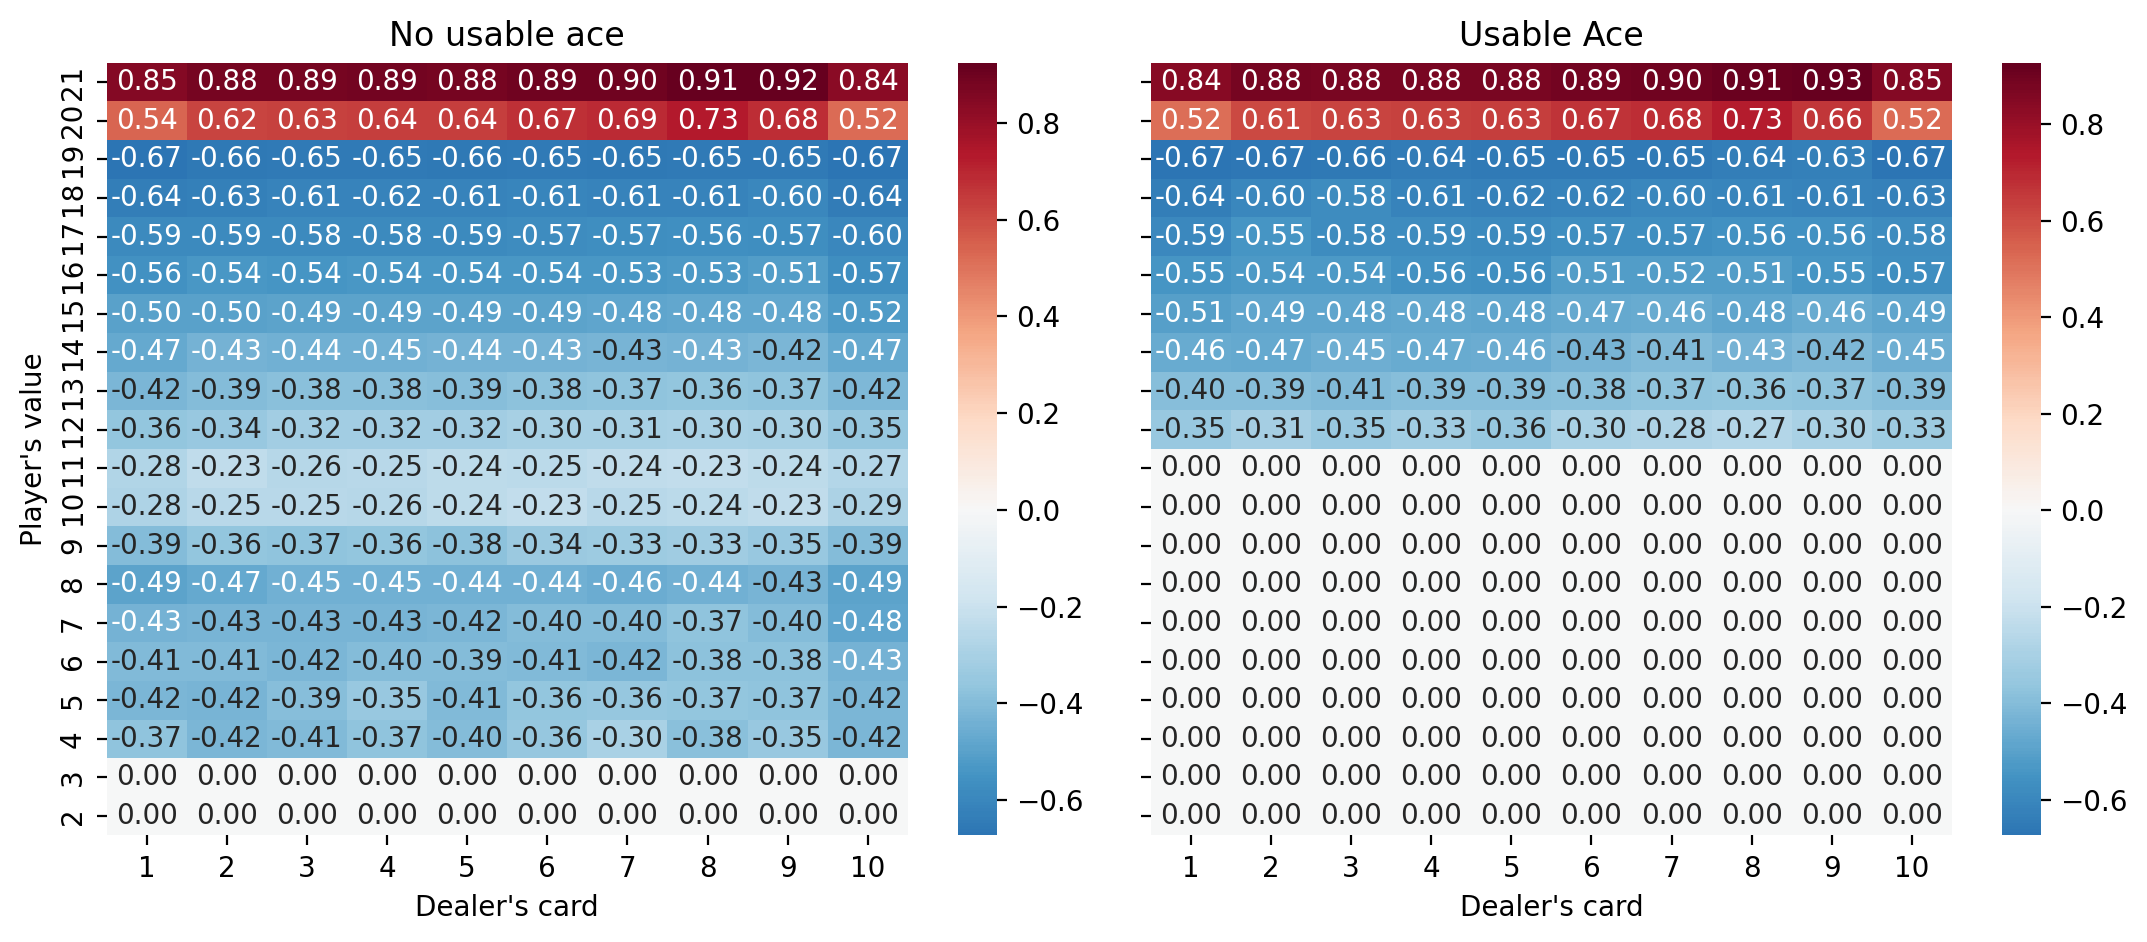

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(11, 4.8), sharey=True)
for axi, vf in zip(ax, [vf_no_ace, vf_ace]):
    sns.heatmap(vf, cmap="RdBu_r", ax=axi, annot=True, fmt="0.2f", center=0.0)
    axi.set_xlabel("Dealer's card")

ax[0].set_ylabel("Player's value")
ax[0].set_title("No usable ace")
ax[1].set_title("Usable Ace")
ax[0].invert_yaxis()
plt.tight_layout()

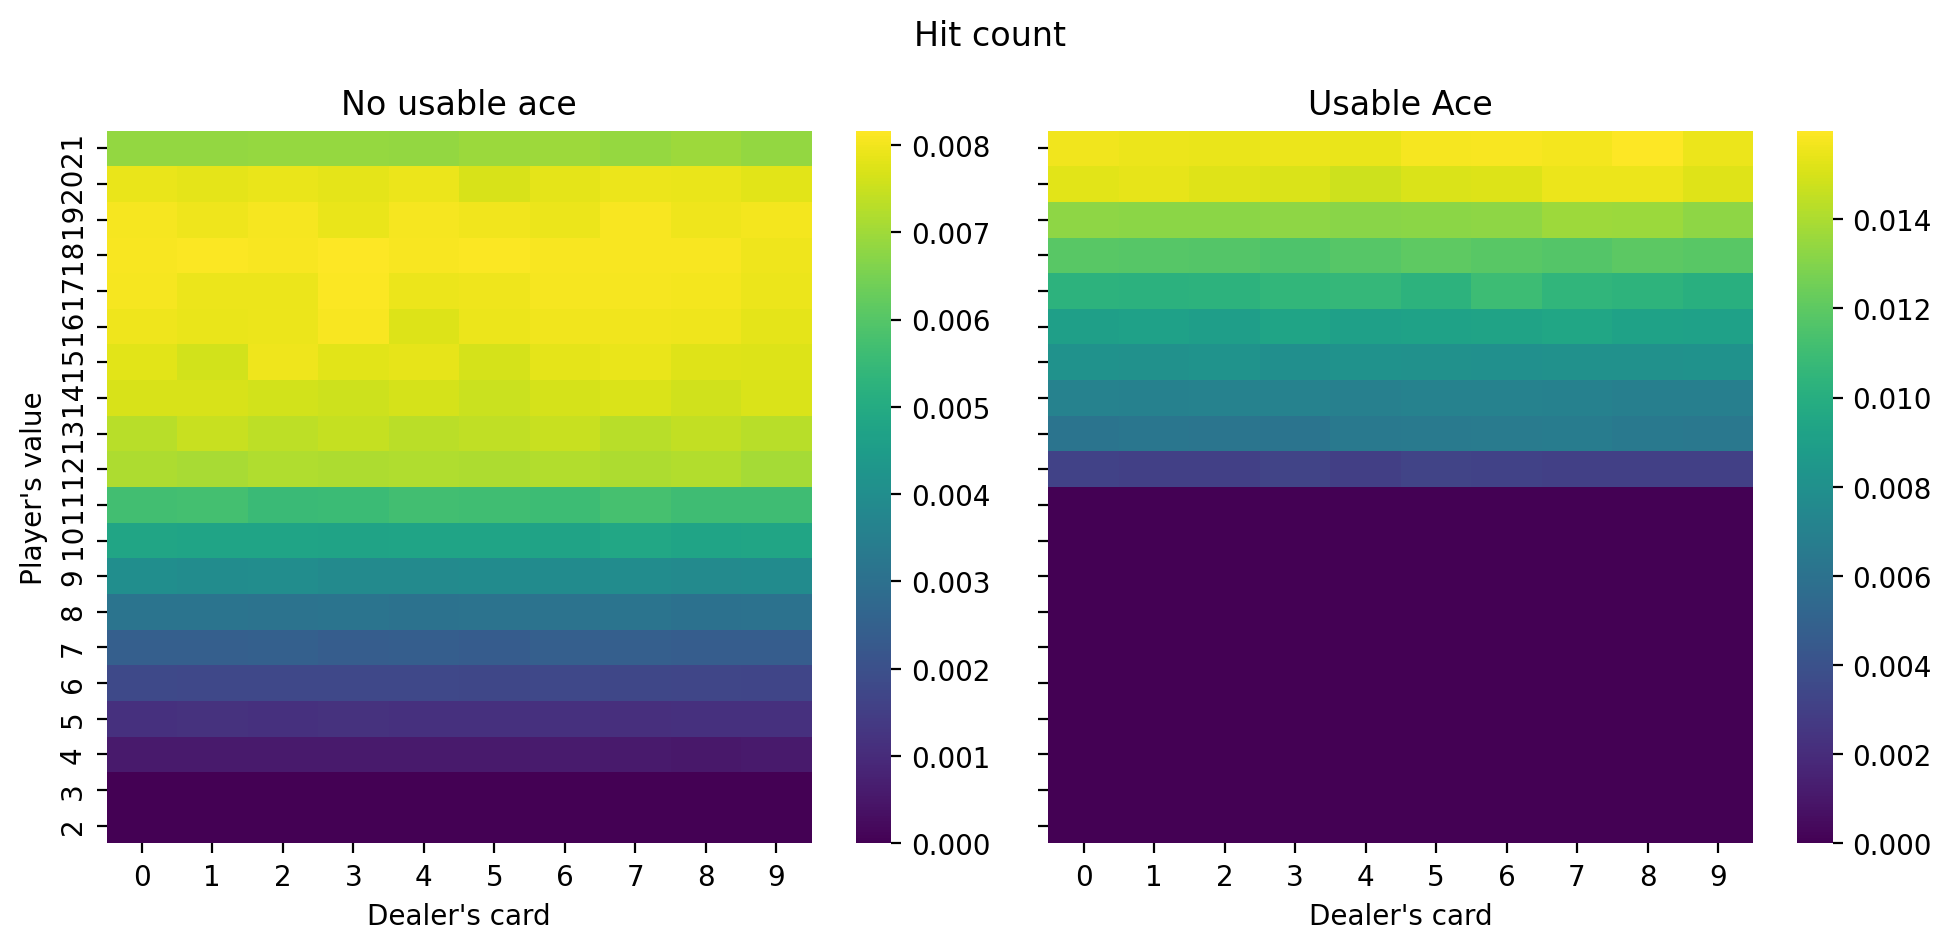

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4.8), sharey=True)

for i, axi in enumerate(ax):
    p_grid = grid_count[:, i, :]
    p_grid = p_grid / p_grid.sum()
    vf = pd.DataFrame(p_grid, index=range_value_cards, )
    sns.heatmap(vf, cmap="viridis", ax=axi)
    axi.set_xlabel("Dealer's card")

ax[0].set_ylabel("Player's value")
ax[0].set_title("No usable ace")
ax[1].set_title("Usable Ace")
ax[0].invert_yaxis()
plt.suptitle("Hit count")
plt.tight_layout()